### Example Implementation
This file goes through every step of the process, using features available to HotDeckImputer.

In [1]:
from hot_deck_imputer import HotDeckImputer
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Generate Data

In [2]:
# Create possibilities for race, sex, and work
race_categories = ['Black', 'White']
sex_categories = ['M', 'F']
work_categories = [0, 1]
np.random.seed(42)  # For reproducibility

# Generate polars frames
donor_data = {
    'donor_assets': [50000, 20000, 300000, 2000, 
                     10000, 10000, 200, 2000, 4000, 500000],
    'race_cell': ['Black','Black','Black','White','White',
                     'White','Black','White','Black','Black'],
    'sex_cell': ['M','F','F','M','F',
                     'M','F','F','M','F'],
    'work_cell': [1,0,1,0,1,
                     0,1,1,1,0],
    'weight': [1, 2, 1, 2, 1,
               2, 1, 2, 1, 2]
}

donor_data = pl.DataFrame(donor_data)

recipient_data = {
    'race_cell': ['Black','Black','Black','White','White',
                     'White','Black','White','Black','Black','Black','Black','White','White'],
    'sex_cell': ['M','F','F','M','F',
                     'M','F','F','M','F', 'F', 'M', 'M', 'F'],
    'work_cell': [1,0,1,0,1,
                     0,1,1,1,0,0,1,0,1],
    'weight': [1, 3, 2, 3, 2,
               1, 4, 2, 1, 3, 4, 2, 1, 1]
}

recipient_data = pl.DataFrame(recipient_data)

#### Create Imputer + Define Cells

In [3]:
imputer = HotDeckImputer(donor_data = donor_data, 
                         imputation_var = 'donor_assets', 
                         weight_var = 'weight', 
                         recipient_data = recipient_data)

In [4]:
# If you are imputing from one dataset to another across years, this will adjust the donor data to the recipient year
imputer.age_dollar_amounts(donor_year_cpi = 223.1, imp_year_cpi = 322.1)

Summary of donor_assets pre CPI aging:
{'mean': 89820.0, 'median': 10000.0, 'min': 200, 'max': 500000, 'std_dev': 170765.50393253707, 'count': 10, 'missing_values': 0}
Summary of donor_assets post CPI aging:
{'mean': 129677.37337516811, 'median': 14437.471985656657, 'min': 288.74943971313314, 'max': 721873.5992828329, 'std_dev': 246542.2179142546, 'count': 10, 'missing_values': 0}


In [5]:
# The variables create cells held in imputer.donor_cells, a dictionary.
# These cells divide the data according to every unique combination of the variables. 
# Key: combination of variables defining cell, Value: pl.DataFrame of data in that cell
variables = ['race_cell','sex_cell']

imputer.define_cells(variables)

# Take a look at cell definitions
imputer.cell_definitions

["race_cell == 'Black' & sex_cell == 'M'",
 "race_cell == 'Black' & sex_cell == 'F'",
 "race_cell == 'White' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'F'"]

In [6]:
# Create the cells after defining them, assuming above looks right
imputer.generate_cells()

In [7]:
# Take a look at the recipient cells
imputer.recipient_cells

{"race_cell == 'Black' & sex_cell == 'M'": shape: (3, 4)
 ┌───────────┬──────────┬───────────┬────────┐
 │ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ str       ┆ str      ┆ i64       ┆ i64    │
 ╞═══════════╪══════════╪═══════════╪════════╡
 │ Black     ┆ M        ┆ 1         ┆ 1      │
 │ Black     ┆ M        ┆ 1         ┆ 1      │
 │ Black     ┆ M        ┆ 1         ┆ 2      │
 └───────────┴──────────┴───────────┴────────┘,
 "race_cell == 'Black' & sex_cell == 'F'": shape: (5, 4)
 ┌───────────┬──────────┬───────────┬────────┐
 │ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ str       ┆ str      ┆ i64       ┆ i64    │
 ╞═══════════╪══════════╪═══════════╪════════╡
 │ Black     ┆ F        ┆ 0         ┆ 3      │
 │ Black     ┆ F        ┆ 1         ┆ 2      │
 │ Black     ┆ F        ┆ 1         ┆ 4      │
 │ Black     ┆ F        ┆ 0         ┆ 3      │
 │ Black     ┆ F        ┆ 0         ┆ 4

In [8]:
# Take a look at donor cells
imputer.donor_cells

{"race_cell == 'Black' & sex_cell == 'M'": shape: (2, 5)
 ┌──────────────┬───────────┬──────────┬───────────┬────────┐
 │ donor_assets ┆ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ ---          ┆ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ f64          ┆ str       ┆ str      ┆ i64       ┆ i64    │
 ╞══════════════╪═══════════╪══════════╪═══════════╪════════╡
 │ 72187.359928 ┆ Black     ┆ M        ┆ 1         ┆ 1      │
 │ 5774.988794  ┆ Black     ┆ M        ┆ 1         ┆ 1      │
 └──────────────┴───────────┴──────────┴───────────┴────────┘,
 "race_cell == 'Black' & sex_cell == 'F'": shape: (4, 5)
 ┌───────────────┬───────────┬──────────┬───────────┬────────┐
 │ donor_assets  ┆ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ ---           ┆ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ f64           ┆ str       ┆ str      ┆ i64       ┆ i64    │
 ╞═══════════════╪═══════════╪══════════╪═══════════╪════════╡
 │ 28874.943971  ┆ Black     ┆ F        ┆ 0         ┆ 2      │
 │ 433124.1

In [9]:
# After deciding that you want to split on work_cell for Black Women, you can do the following
imputer.split_cell("race_cell == 'Black' & sex_cell == 'F'", "work_cell")


In [10]:
# Cell definitions have changed, as have donor cells
imputer.cell_definitions

["race_cell == 'Black' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'F'",
 "race_cell == 'Black' & sex_cell == 'F' & work_cell == 0",
 "race_cell == 'Black' & sex_cell == 'F' & work_cell == 1"]

In [11]:
# Take a look at donor and recipient after splitting
imputer.donor_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 1"]

donor_assets,race_cell,sex_cell,work_cell,weight
f64,str,str,i64,i64
433124.15957,"""Black""","""F""",1,1
288.74944,"""Black""","""F""",1,1


In [12]:
imputer.recipient_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 1"]

race_cell,sex_cell,work_cell,weight
str,str,i64,i64
"""Black""","""F""",1,2
"""Black""","""F""",1,4


In [13]:
imputer.recipient_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 0"]

race_cell,sex_cell,work_cell,weight
str,str,i64,i64
"""Black""","""F""",0,3
"""Black""","""F""",0,3
"""Black""","""F""",0,4


#### Impute Data + Apply Smoothing

In [14]:
imputer.impute()

In [15]:
# Notice imp_donor_assets has been added to recipient cells
imputer.recipient_cells

{"race_cell == 'Black' & sex_cell == 'M'": shape: (3, 5)
 ┌───────────┬──────────┬───────────┬────────┬──────────────────┐
 │ race_cell ┆ sex_cell ┆ work_cell ┆ weight ┆ imp_donor_assets │
 │ ---       ┆ ---      ┆ ---       ┆ ---    ┆ ---              │
 │ str       ┆ str      ┆ i64       ┆ i64    ┆ f64              │
 ╞═══════════╪══════════╪═══════════╪════════╪══════════════════╡
 │ Black     ┆ M        ┆ 1         ┆ 1      ┆ 5774.988794      │
 │ Black     ┆ M        ┆ 1         ┆ 1      ┆ 5774.988794      │
 │ Black     ┆ M        ┆ 1         ┆ 2      ┆ 72187.359928     │
 └───────────┴──────────┴───────────┴────────┴──────────────────┘,
 "race_cell == 'White' & sex_cell == 'M'": shape: (3, 5)
 ┌───────────┬──────────┬───────────┬────────┬──────────────────┐
 │ race_cell ┆ sex_cell ┆ work_cell ┆ weight ┆ imp_donor_assets │
 │ ---       ┆ ---      ┆ ---       ┆ ---    ┆ ---              │
 │ str       ┆ str      ┆ i64       ┆ i64    ┆ f64              │
 ╞═══════════╪══════════╪══

In [16]:
imputer.recipient_data

race_cell,sex_cell,work_cell,weight,imp_donor_assets
str,str,i64,i64,f64
"""Black""","""M""",1,1,5774.988794
"""Black""","""M""",1,1,5774.988794
"""Black""","""M""",1,2,72187.359928
"""White""","""M""",0,3,14437.471986
"""White""","""M""",0,1,2887.494397
…,…,…,…,…
"""Black""","""F""",0,3,28874.943971
"""Black""","""F""",0,3,28874.943971
"""Black""","""F""",0,4,28874.943971


In [17]:
# To smooth out clusters, you can add random noise proportional to the standard deviation of the variable 
# and set a floor value that the noise cannot send a value below (to avoid negative or impossible values)
imputer.apply_random_noise(variation_stdev = (1/6), floor_noise = 1.5)

In [18]:
# Take a look at the random noise used, initialized after above function is called
imputer.random_noise

0.16666666666666666

#### Examine Results

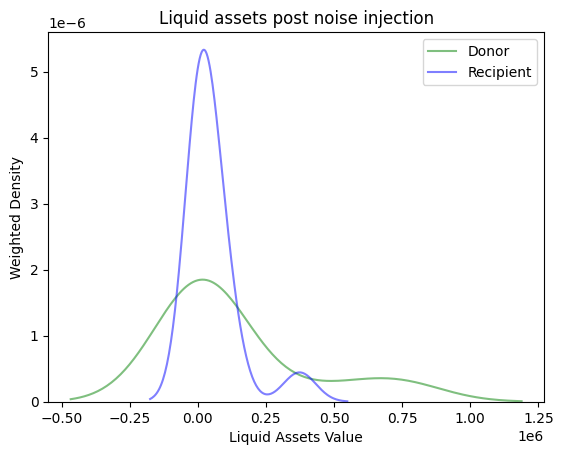

In [22]:
# Compare the input to the output in the process
plot_data = imputer.recipient_data[['weight','imp_donor_assets']]
plot_data_donor = imputer.donor_data[['weight','donor_assets']]

# Create a weighted histogram plot for donor data
sns.kdeplot(data=plot_data_donor, x='donor_assets', weights='weight', color='green', label='Donor', alpha=0.5)

# Create a weighted histogram plot for recipient data
sns.kdeplot(data=plot_data, x='imp_donor_assets', weights='weight', color='blue', label='Recipient', alpha=0.5)

# Add titles and labels
plt.title('Liquid assets post noise injection')
plt.xlabel('Liquid Assets Value')
plt.ylabel('Weighted Density')

# Add a legend to differentiate between recipient and donor data
plt.legend()

# Show the plot
plt.show()

In [ ]:
imputer.gen_analysis_file('hot_deck_stats', '')

Cell data written to '.\hot_deck_stats.xlsx'.


In [ ]:
imputer.gen_analysis_file('hot_deck_stats')

Cell data written to '.\hot_deck_stats.xlsx'.
